In [50]:
import glob, json, os
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

img_paths = glob.glob('./pictures/*')
img_paths.sort()

#img_paths = img_paths[: ]
img_paths

['./pictures\\airplane.jpeg',
 './pictures\\airplane2.jpeg',
 './pictures\\boy_drawing.jpg',
 './pictures\\children_playing.jpg',
 './pictures\\children_studying.jpg',
 './pictures\\farmer_working.jpeg',
 './pictures\\girl_drawing.jpeg',
 './pictures\\girl_studying.jpeg',
 './pictures\\playing_kite.jpg',
 './pictures\\sunset.jpeg']

In [51]:
validation_annotations = json.load(
    open('./captions.json', encoding='utf-8')
)

validation_annotations

[{'url': '', 'image_id': 'airplane.jpeg', 'caption': ['飞机飞过蔚蓝的天空']},
 {'url': '', 'image_id': 'airplane2.jpeg', 'caption': ['飞机飞过厚厚的云层']},
 {'url': '', 'image_id': 'boy_drawing.jpg', 'caption': ['一个小男孩正在画室认真地画画']},
 {'url': '',
  'image_id': 'children_playing.jpg',
  'caption': ['小朋友们正在一起玩老鹰抓小鸡的游戏']},
 {'url': '', 'image_id': 'children_studying.jpg', 'caption': ['小朋友在教室里认真地学习']},
 {'url': '',
  'image_id': 'farmer_working.jpeg',
  'caption': ['带着草帽的农夫在绿油油的田里劳作']},
 {'url': '', 'image_id': 'girl_drawing.jpeg', 'caption': ['一个可爱的小女孩拿着画笔画画']},
 {'url': '', 'image_id': 'girl_studying.jpeg', 'caption': ['一个小女孩正在认真写作业']},
 {'url': '', 'image_id': 'playing_kite.jpg', 'caption': ['一群孩子在草地上放风筝']},
 {'url': '', 'image_id': 'sunset.jpeg', 'caption': ['海边的日落把海水都映红了']}]

In [52]:
validation_annotations_dict = {x['image_id']: x['caption'][0] for x in validation_annotations}
validation_annotations_dict

{'airplane.jpeg': '飞机飞过蔚蓝的天空',
 'airplane2.jpeg': '飞机飞过厚厚的云层',
 'boy_drawing.jpg': '一个小男孩正在画室认真地画画',
 'children_playing.jpg': '小朋友们正在一起玩老鹰抓小鸡的游戏',
 'children_studying.jpg': '小朋友在教室里认真地学习',
 'farmer_working.jpeg': '带着草帽的农夫在绿油油的田里劳作',
 'girl_drawing.jpeg': '一个可爱的小女孩拿着画笔画画',
 'girl_studying.jpeg': '一个小女孩正在认真写作业',
 'playing_kite.jpg': '一群孩子在草地上放风筝',
 'sunset.jpeg': '海边的日落把海水都映红了'}

In [53]:
img_paths_basenames = [os.path.basename(x) for x in img_paths]
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]
img_captions
img_paths

['./pictures\\airplane.jpeg',
 './pictures\\airplane2.jpeg',
 './pictures\\boy_drawing.jpg',
 './pictures\\children_playing.jpg',
 './pictures\\children_studying.jpg',
 './pictures\\farmer_working.jpeg',
 './pictures\\girl_drawing.jpeg',
 './pictures\\girl_studying.jpeg',
 './pictures\\playing_kite.jpg',
 './pictures\\sunset.jpeg']

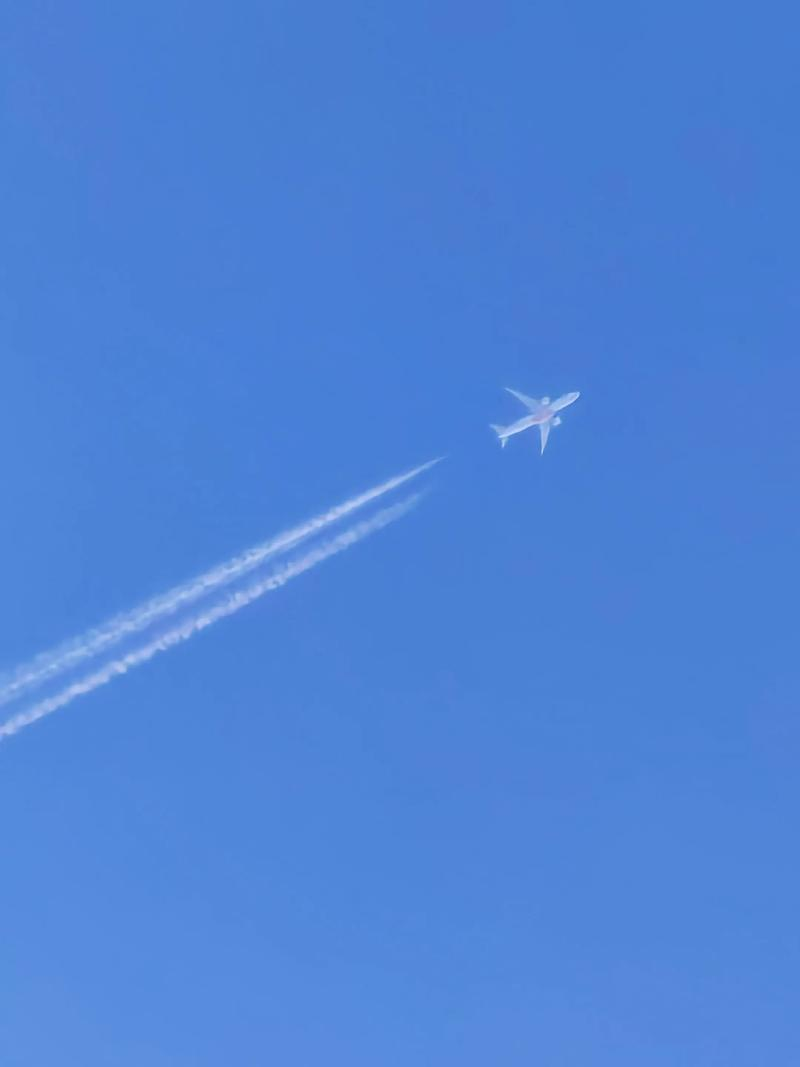

In [54]:
Image.open(img_paths[0])

In [55]:
img_captions[0]

'飞机飞过蔚蓝的天空'

# 加载CLIP模型

In [56]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch
model = ChineseCLIPModel.from_pretrained("../../models/chinese-clip-vit-base-patch16") # 中文clip模型
processor = ChineseCLIPProcessor.from_pretrained("../../models/chinese-clip-vit-base-patch16") # 预处理

# 图像编码

In [60]:
img_image_feat = []

batch_size = 10
print(len(img_captions))
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    imgs = [ Image.open(path) for path in img_paths[idx*batch_size: (idx+1)*batch_size] ]
    
    if len(imgs) == 0:
        break
    
    inputs = processor(images=imgs, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)

    #break
print("finish")       
img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

10


C:\Users\Mi\AppData\Local\Temp\ipykernel_4836\804265804.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/2 [00:00<?, ?it/s]

finish


In [61]:
img_image_feat.shape # 20张图片 512 维度

(10, 512)

# 文本编码

In [62]:
img_texts_feat = []

batch_size = 10
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    texts = [ text for text in img_captions[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
    #break
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

C:\Users\Mi\AppData\Local\Temp\ipykernel_4836\3684681726.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/2 [00:00<?, ?it/s]

In [63]:
img_texts_feat.shape

(10, 512)

# 尝试1：相似度计算

In [64]:
query_idx = 2

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T) # 矩阵计算
print(sim_result)
sim_idx = sim_result.argsort()[::-1][1:4]

[0.26927546 0.2730464  0.39822236 0.28388903 0.2916218  0.25896677
 0.40879542 0.3127258  0.26047802 0.26753032]


输入文本:  一个小男孩正在画室认真地画画


([], [])

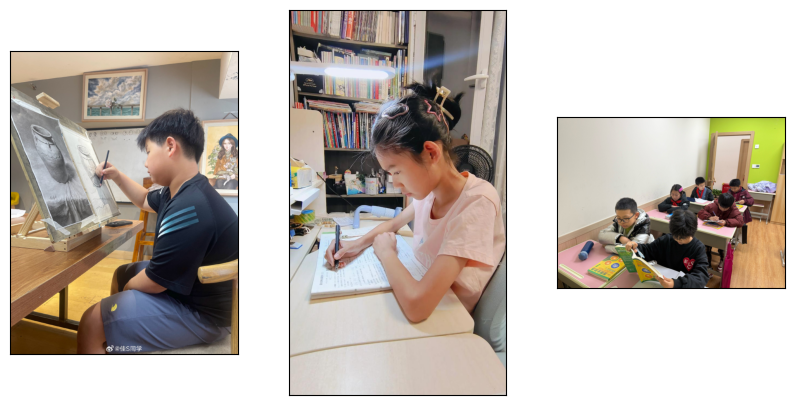

In [65]:
print('输入文本: ', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

In [66]:
query_idx = 2

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

文本识别结果:  ['小朋友在教室里认真地学习', '一个小女孩正在认真写作业', '小朋友们正在一起玩老鹰抓小鸡的游戏']


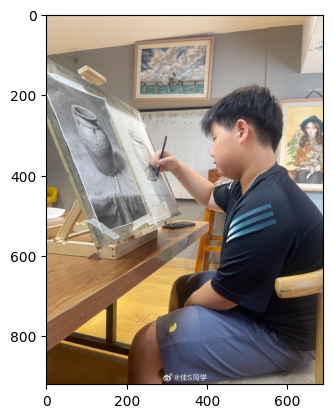

In [67]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions[x] for x in sim_idx])

# 文本标签编码

In [68]:
import jieba

In [69]:
jieba.lcut('今天天气很好，心情也很好。')

['今天天气', '很', '好', '，', '心情', '也', '很', '好', '。']

In [70]:
jieba.lcut(img_captions[0])

['飞机', '飞过', '蔚蓝', '的', '天空']

In [71]:
img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])

In [72]:
img_captions2words[:10]

['飞机', '飞过', '蔚蓝', '的', '天空', '飞机', '飞过', '厚厚的', '云层', '一个']

In [73]:
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))

In [74]:
img_captions2words[:10]

['农夫', '可爱', '小朋友', '教室', '田里', '天空', '小女孩', '飞机', '画画', '小男孩']

In [75]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

C:\Users\Mi\AppData\Local\Temp\ipykernel_4836\3640130202.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):


  0%|          | 0/2 [00:00<?, ?it/s]

# 尝试2：标签相似度计算

In [76]:
query_idx = 2

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:7]

文本识别结果:  ['认真', '画室', '都映', '作业', '画画', '孩子']


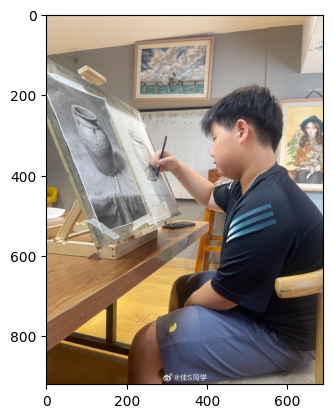

In [77]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])